<a href="https://colab.research.google.com/github/objectc/CNN-with-TensorFlow2.0-and-Keras/blob/master/inception_naive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 55kB/s 
     |████████████████████████████████| 61kB 26.5MB/s 
     |████████████████████████████████| 419kB 56.9MB/s 
     |████████████████████████████████| 3.0MB 38.4MB/s 


In [0]:
# Import all the necessary files!
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [4]:
print(tf.__version__)

2.0.0-alpha0


In [0]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization

In [6]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 17s 0us/step


In [7]:
X_train_full = X_train_full/255.0
X_test = X_test/255.0
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
input_shape = X_train_full[0].shape
input_shape

(32, 32, 3)

## Naive Inception Model

![Inception V1](https://raw.githubusercontent.com/objectc/CNN-with-TensorFlow2.0-and-Keras/master/res/inception_v1.jpg)

[Source: Going deeper with convolutions](https://arxiv.org/pdf/1409.4842v1.pdf)

In [0]:
def generate_inception_module(inputs):
  output_1x1 = Conv2D(64, (1,1), padding='same')(inputs)
  output_1x1 = BatchNormalization()(output_1x1)
  output_1x1 = Activation('relu')(output_1x1)
  
  output_3x3 = Conv2D(96, (1,1), padding='same')(inputs)
  output_3x3 = BatchNormalization()(output_3x3)
  output_3x3 = Activation('relu')(output_3x3)
  output_3x3 = Conv2D(128, (3,3), padding='same')(output_3x3)
  output_3x3 = BatchNormalization()(output_3x3)
  output_3x3 = Activation('relu')(output_3x3)
  
  output_5x5 = Conv2D(16, (1,1), padding='same')(inputs)
  output_5x5 = BatchNormalization()(output_5x5)
  output_5x5 = Activation('relu')(output_5x5)
  output_5x5 = Conv2D(32, (5,5), padding='same')(output_5x5)
  output_5x5 = BatchNormalization()(output_5x5)
  output_5x5 = Activation('relu')(output_5x5)
  output_pooling = MaxPooling2D((3,3), padding='same', strides=1)(inputs)
  output_pooling = Conv2D(32, (1,1), padding='same')(output_pooling)
  output_pooling = BatchNormalization()(output_pooling)
  output_pooling = Activation('relu')(output_pooling)
  return keras.layers.concatenate([output_1x1, output_3x3, output_5x5, output_pooling], axis=3)

In [0]:
keras.backend.clear_session()
inputs = Input(input_shape)
x = generate_inception_module(inputs)
# x = generate_inception_module(x)
x = Conv2D(32, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = keras.layers.AveragePooling2D((2,2), padding='same', strides=1)(x)
x = Flatten()(x)
# x = Dense(1024, activation='relu')(x)
output = Dense(len(classes), activation='softmax')(x)

In [0]:
model = Model(inputs, output)

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 96)   384         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 16)   64          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v2_1 (Batch (None, 32, 32, 96)   384         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 10:
        lrate = 0.0005
    if epoch > 20:
        lrate = 0.0003
    return lrate

In [0]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001,decay=1e-6), 
              loss=keras.losses.sparse_categorical_crossentropy, 
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [0]:
from keras_preprocessing.image import ImageDataGenerator

In [0]:
traingen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=15,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=0,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format='channels_last',
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
traingen.fit(X_train_full)
X_train_gen = traingen.flow(X_train_full, y_train_full)

In [35]:
history = model.fit(X_train_gen, epochs=30, validation_data=(X_test, y_test), callbacks=[keras.callbacks.LearningRateScheduler(lr_schedule)])

Epoch 1/30
1563/1563 [==============================] - 44s 28ms/step - loss: 1.8773 - sparse_categorical_accuracy: 0.4150 - val_loss: 1.5559 - val_sparse_categorical_accuracy: 0.4763
Epoch 2/30
1563/1563 [==============================] - 39s 25ms/step - loss: 1.3447 - sparse_categorical_accuracy: 0.5178 - val_loss: 1.2898 - val_sparse_categorical_accuracy: 0.5554
Epoch 3/30
1563/1563 [==============================] - 40s 25ms/step - loss: 1.2519 - sparse_categorical_accuracy: 0.5549 - val_loss: 1.1579 - val_sparse_categorical_accuracy: 0.6002
Epoch 4/30
1563/1563 [==============================] - 39s 25ms/step - loss: 1.1769 - sparse_categorical_accuracy: 0.5856 - val_loss: 1.1193 - val_sparse_categorical_accuracy: 0.6102
Epoch 5/30
1563/1563 [==============================] - 40s 26ms/step - loss: 1.1302 - sparse_categorical_accuracy: 0.6045 - val_loss: 1.0741 - val_sparse_categorical_accuracy: 0.6292
Epoch 6/30
1563/1563 [==============================] - 39s 25ms/step - loss: 1.

In [0]:

def plot_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['sparse_categorical_accuracy'])
  plt.plot(history.history['val_sparse_categorical_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validate'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validate'], loc='upper left')
  plt.show()

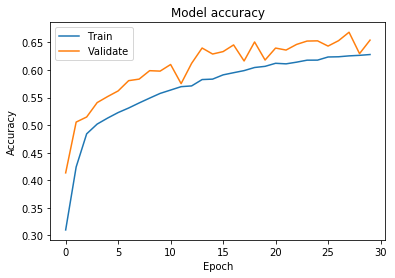

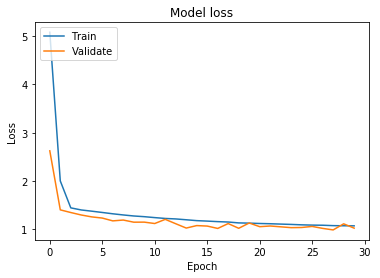

In [18]:
plot_history(history)

In [19]:
model.fit(X_train_gen, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
1563/1563 [==============================] - 42s 27ms/step - loss: 1.0567 - sparse_categorical_accuracy: 0.6295 - val_loss: 0.9361 - val_sparse_categorical_accuracy: 0.6804
Epoch 2/20
1563/1563 [==============================] - 41s 26ms/step - loss: 1.0565 - sparse_categorical_accuracy: 0.6316 - val_loss: 1.0156 - val_sparse_categorical_accuracy: 0.6546
Epoch 3/20
1563/1563 [==============================] - 42s 27ms/step - loss: 1.0505 - sparse_categorical_accuracy: 0.6337 - val_loss: 1.0647 - val_sparse_categorical_accuracy: 0.6484
Epoch 4/20
1563/1563 [==============================] - 42s 27ms/step - loss: 1.0435 - sparse_categorical_accuracy: 0.6373 - val_loss: 1.0402 - val_sparse_categorical_accuracy: 0.6555
Epoch 5/20
1563/1563 [==============================] - 41s 26ms/step - loss: 1.0416 - sparse_categorical_accuracy: 0.6374 - val_loss: 1.0107 - val_sparse_categorical_accuracy: 0.6554
Epoch 6/20
 658/1563 [===========>..................] - ETA: 22s - loss: 1.0407 

KeyboardInterrupt: ignored

In [0]:
plot_history(model.history)

In [0]:
keras.backend.clear_session()
inputs = Input(input_shape)
x = generate_inception_module(inputs)
x = generate_inception_module(x)
x = generate_inception_module(x)
# x = Conv2D(32, (3,3), padding='same', activation='rrelu')(x)
# x = Conv2D(32, (3,3), padding='same', activation='rrelu')(x)
# x = MaxPooling2D(2, 2)(x)
# x = Conv2D(64, (3,3), padding='same', activation='rrelu')(x)
# x = Conv2D(64, (3,3), padding='same', activation='rrelu')(x)
# x = MaxPooling2D(2, 2)(x)
x = AveragePooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(1024, activation='rrelu')(x)
output = Dense(len(classes), activation='softmax')(x)

In [0]:
model = Model(inputs, output)

In [0]:
model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.sparse_categorical_crossentropy, 
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [0]:
model.fit(X_train_gen, epochs=40, validation_data=(X_test, y_test))